# Grid Trading Bot 

Build a simple grid trading algorithm, introduce concepts to readers such as Transaction costs, stop losses and order sizing

In [1]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os

from alpha_vantage.foreignexchange import ForeignExchange
import warnings

In [2]:
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
# I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

## Gather FX Historical Data
I will use Alpha vantage to gather historical data, in order for you to collect data yourself, you'll need to create an free account. visit the website
https://www.alphavantage.co/ and follow the instructions there. <br>
<br>
It's never a good practice to copy your credentials as free text into your code.
I've placed my credentials in a .env file which stays with me locally.

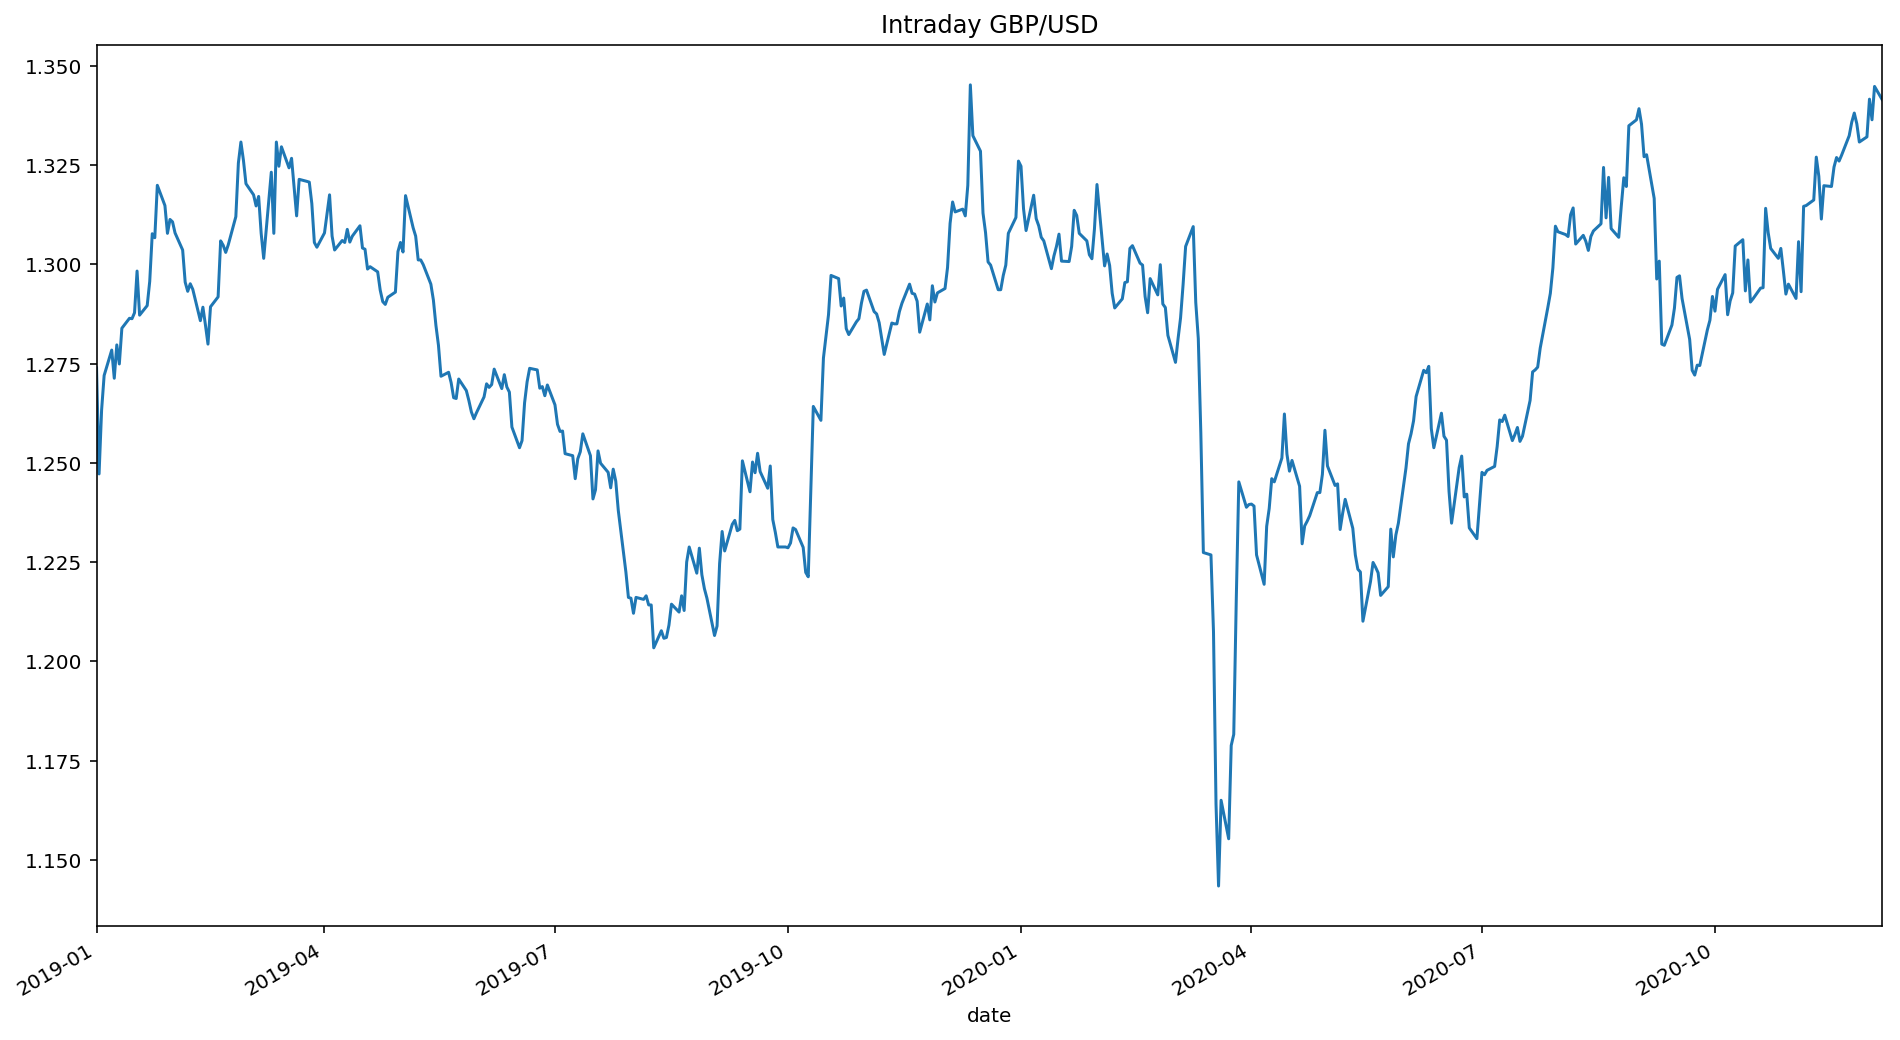

In [3]:
cc = ForeignExchange(key=os.environ['alpha_vantage_token'],output_format='pandas')

# We will retreive daily OHLC prices, Alpha vantage also contains intraday results which are difficult to come by elsewhere

data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')

# Let's just look at 2015 onwards 

data_df.sort_index(inplace=True)
data_df = data_df.loc['2019-01-01':]

# Plot the results to ensure everything worked

data_df['4. close'].plot()
plt.title('Intraday GBP/USD')
plt.show()

In [4]:
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

# Algorithm Strategy Definition 
To do the backtesting, we will use the Backtrader Python package https://www.backtrader.com/. It's a bigger learning curve to compared to other platforms such as Quantopian, but I really enjoy the added flexibility and the fact you can easily integrate with other Python packages/platforms.

In [15]:
class grid_bander(bt.Strategy):

    params = dict(
        bands=4
        ,spread=0.002
        ,periods=25)
    
    def __init__(self):
        
        self.mva = bt.ind.ExponentialMovingAverage(self.data.close,period=self.p.periods ,plot=True, plotname='Simple Moving Average', subplot=False)
        
        # Against the grid 
        self.increase_sig = self.data.close > self.data.close(-1)
        
        
        
        
        self.decrease_sig = self.data.close < self.data.close(-1)
        


    def next(self):
        
        if not self.position:  # not in the market
            if self.increase_sig > 0:  # TODO - if fast crosses slow to the upside
                self.order_target_size(target=4000)   # positive: enter Long, negative: enter Short
                
        elif self.decrease_sig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position 
        

In [419]:
class grid_bander_bands(bt.Strategy):
# set 

    params = dict(
        bands=4
        ,spread=0.005
        ,periods=25)
    
    def log(self, txt, dt=None, time=None):
        """ Logging function for this strategy"""
        dt = dt or self.data0.datetime.date(0)
        time = time or self.data0.datetime.time(0)
        print('%s %s, %s' % (dt.isoformat(), time.isoformat(), txt))
    
        
    def notify_trade(self, trade):
        if trade.justopened:
            print('----TRADE OPENED----')
            print('Size: %f, Price: %f, Value: %f' % (trade.size, trade.price, trade.value))
            print('-' * 25)
        elif trade.isclosed:
            print('----TRADE CLOSED----')
            print('Profit, Gross {}, Net {}, Price {}, Amount: {}'.format(
                trade.pnl,
                trade.pnlcomm,
                trade.price,
                trade.value))
            print('-' * 25)
        else:
            return
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log("BUY EXECUTED, %f" % order.executed.price)
            elif order.issell():
                self.log("SELL EXECUTED, %f. BALANCE: %f. MARGIN REMAINING: %f." %
                         (order.executed.price,
                          cerebro.broker.getvalue(),
                          cerebro.broker.get_cash()
                          ))
            
    
    def __init__(self):
        
        self.mva = bt.ind.ExponentialMovingAverage(self.data.close,period=self.params.periods ,plot=True, plotname='Simple Moving Average', subplot=False)
        
        # Against the grid 
        self.increase_sig = self.data.close > (self.data.close(-1) + self.params.spread)

        
        #self.decrease_sig = self.data.close < (self.data.close(-1) - self.params.spread)
        #self.decrease_sig_2 = self.data.close > (self.data.close(-1) - (self.params.spread * 2))
        
    
    def next(self):
        
        if not self.position:  # not in the market
            self.buy(price=1.2, exectype=bt.Order.Limit, size=8000)
            
            #self.log('BUYING AT %f. BALANCE: %f. MARGIN REMAINING: %f.' % (self.data.close[0], cerebro.broker.getvalue(),cerebro.broker.get_cash()))
        
        self.close(price=1.3, exectype=bt.Order.Limit)
        #self.log('CLOSING AT %f' % self.data.close[0])

## Run the strategy over the last 2 years 

In [420]:
%%time

cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
#risky risky
#cerebro.broker.setcommission(commission=0, leverage=1)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(grid_bander_bands)
results = cerebro.run()

2019-09-03 00:00:00, BUY EXECUTED, 1.200000
----TRADE OPENED----
Size: 8000.000000, Price: 1.200000, Value: 9600.000000
-------------------------
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.300000. BALANCE: 11750.400000. MARGIN REMAINING: 354000.000000.
2019-10-21 00:00:00, SELL EXECUTED, 1.

Sharpe: 5.278
Norm. Annual Return: 14.65%
Max Drawdown: 3.85%


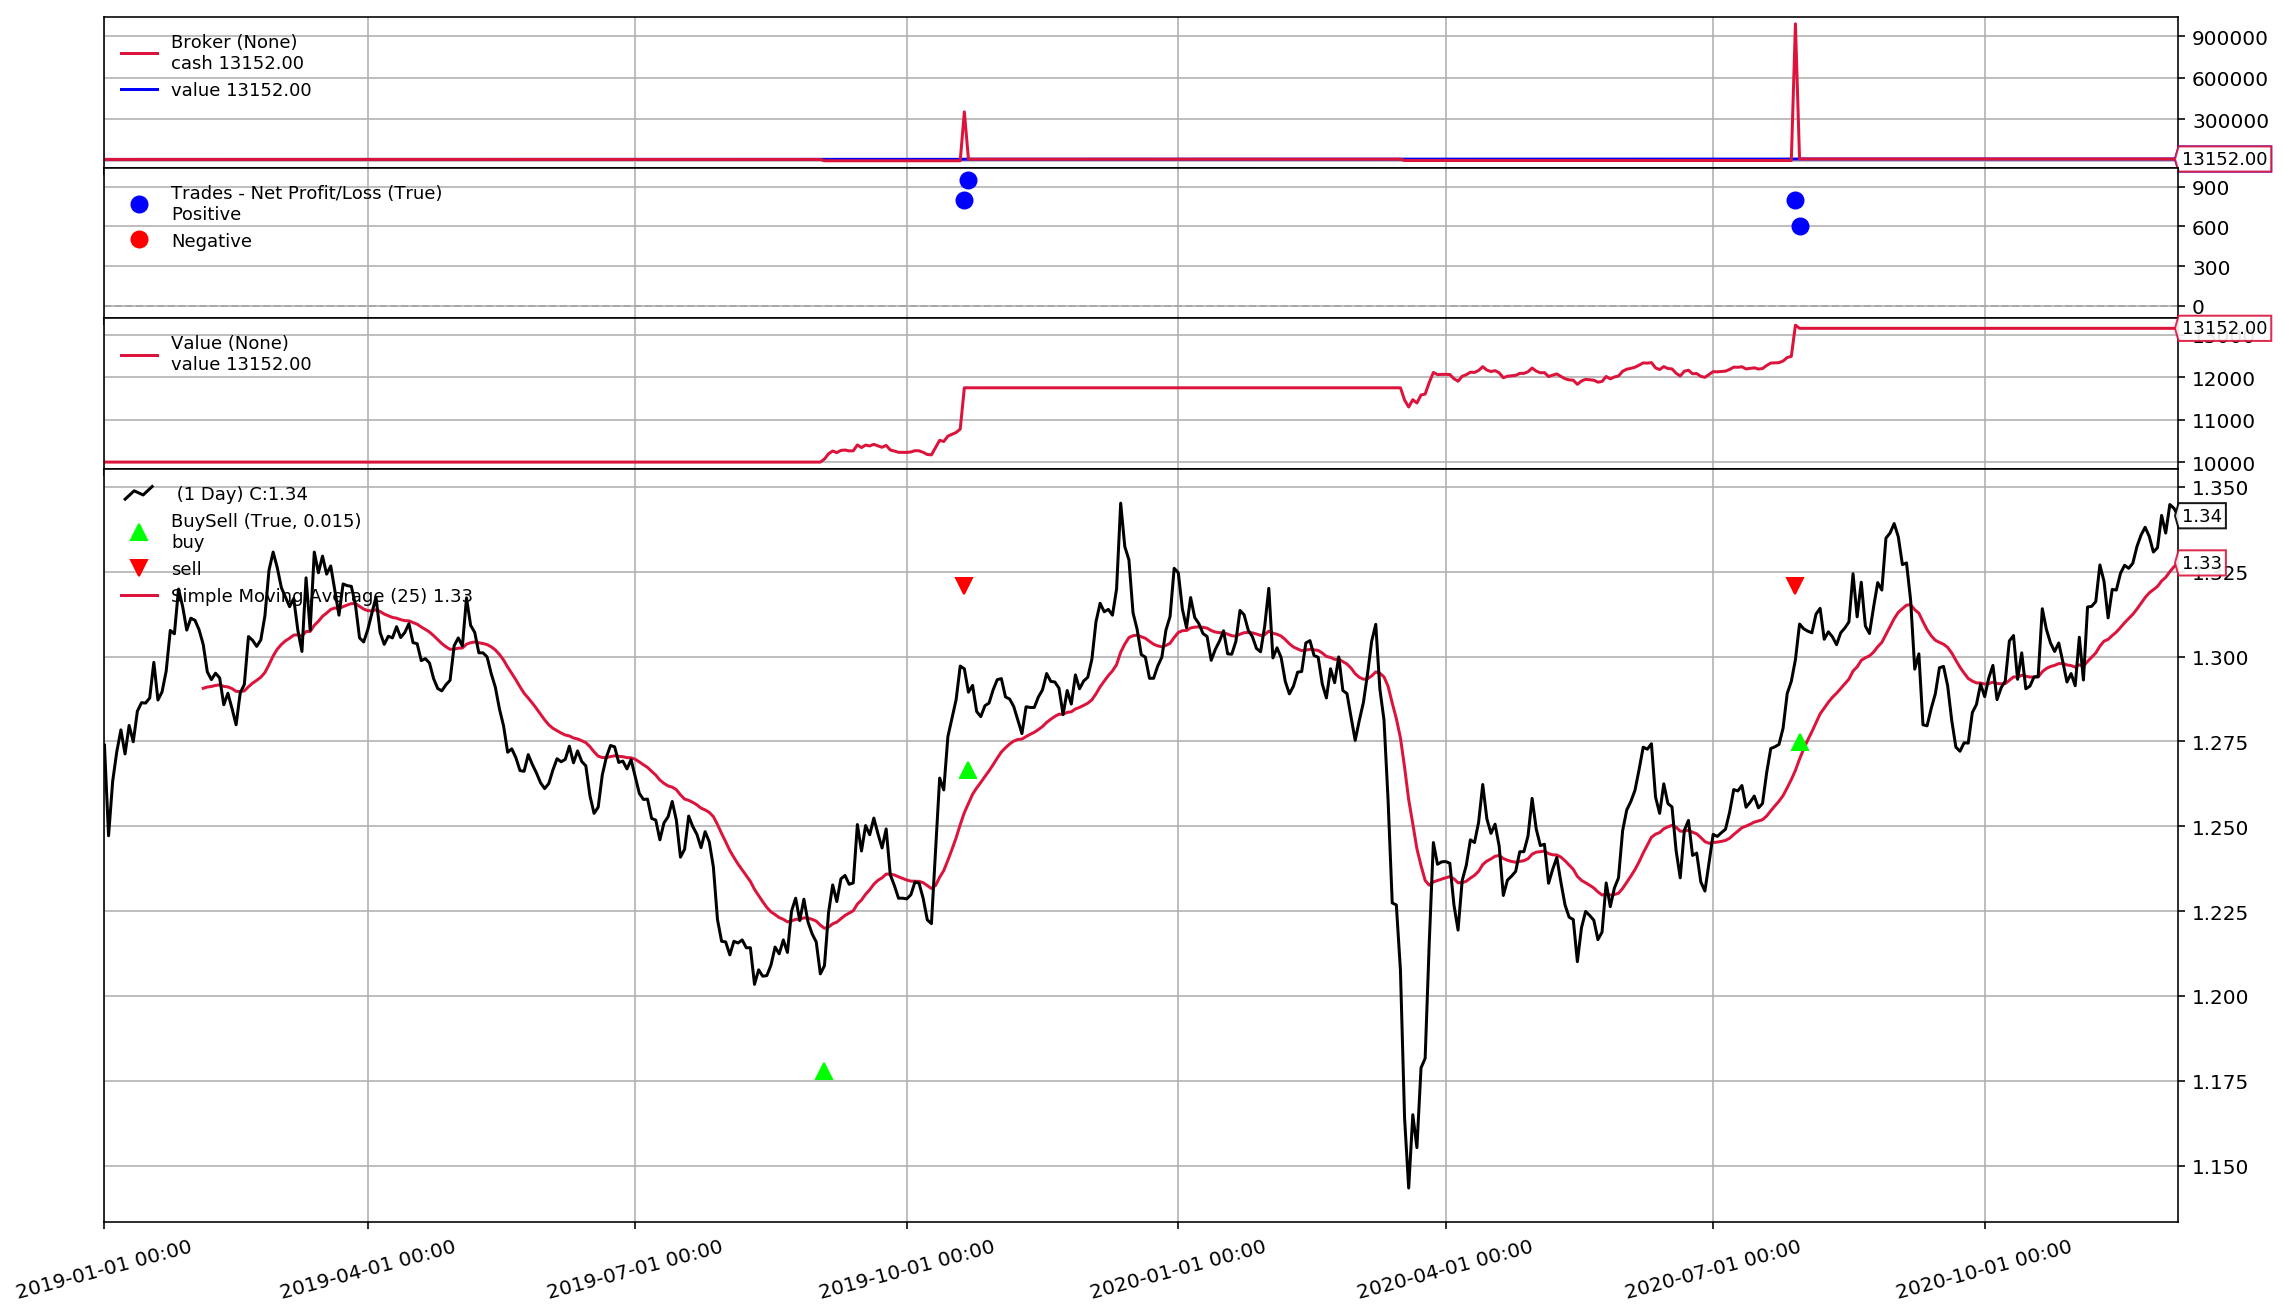

[[<Figure size 1152x648 with 4 Axes>]]

In [421]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot(iplot=False, volume=False, width=20, style='line')